this use heatmap instead of imshow to generate oncoprint should be adopted from now on.

In [1]:
import pandas as pd
import numpy as np
import string as s
import seaborn as sns
import math
# import tables
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style, colors
from itertools import groupby
import matplotlib.patches as patches
from matplotlib import gridspec
import scipy.stats as stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata, leaves_list
from scipy.spatial.distance import pdist
from scipy.ndimage.interpolation import shift
# matplotlib.style.use('ggplot')
# %matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8, 6)
# matplotlib.rcParams['figure.facecolor'] = 'white'
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets.samples_generator import make_swiss_roll
matplotlib.style.use('ggplot')
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [56]:
# choose color from here
# http://colorbrewer2.org/#type=diverging&scheme=RdYlBu&n=4

# 1. Overview

 53 samples in total, 20 hiv+, 18 hiv-, 7 hiv+ controls, 7 hiv- controls

https://www.bcgsc.ca/jira/browse/DA-167

https://www.bcgsc.ca/jira/browse/PIPE-1102

118 patients are here:

/projects/trans_scratch/validations/workspace/szong/Cervical/mutsig2cv/118_patients.txt 

we lost two hypermutated cases when using 118 patients as discovery cohort.

constants for notebook

In [199]:
wkdir = '/projects/da_workspace/DA-167_Cervical_epi_clustering/'
mark = 'H3K4me3'
# mark = 'H3K27ac'
overlap = 0.1
distance = 'correlation'
linkage = 'ward'

# 2. get all narrow peak and broad peak files

In [196]:
%%bash -s $wkdir $mark
cd $1
wkdir=$1
mark=$2
echo $wkdir, $mark
ls -1 /projects/chipseq/macs/A*/75nt/hg19a/bwa-mem-0.7.6a-sb/MACS_2.1.1.20160309/*$mark*Peak > a.tmp
cat a.tmp |awk -F "/" '{print $5"\t"$0}'|awk -F "_" '{print $3"\t"$0}'>d.tmp
while read a b c;do grep $b 57_chipseq_samples_library_ids.csv|cut -f 1|\
awk -v lib=$b -v path=$c -v mark=$a -F "-01" '{print $1"\t"lib"\t"mark"\t"path}' ;done \
< d.tmp |sort -k1 -k2 > $mark"_peak_file_path.txt"
rm a.tmp  d.tmp 
head -2 $mark"_peak_file_path.txt"
wc -l $mark"_peak_file_path.txt"

/projects/da_workspace/DA-167_Cervical_epi_clustering/, H3K4me3
HTMCP-03-06-02001	A84611	H3K4me3	/projects/chipseq/macs/A84611/75nt/hg19a/bwa-mem-0.7.6a-sb/MACS_2.1.1.20160309/A84611_H3K4me3_peaks.narrowPeak
HTMCP-03-06-02002	A94512	H3K4me3	/projects/chipseq/macs/A94512/75nt/hg19a/bwa-mem-0.7.6a-sb/MACS_2.1.1.20160309/A94512_H3K4me3_peaks.narrowPeak
53 H3K4me3_peak_file_path.txt


In [197]:
# missing files for H3K4me3:
#     HTMCP-03-06-02195-01B	positive	non mutated A94364
#     HTMCP-03-06-02256-01A	negative	mutated	A84814



# 3. intersect with promoters

In [198]:
%%bash -s $wkdir $mark
#sort peak files and intersect with merged/split peak regions, required 50% overlap
promoters='/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/hg19v69_genes.TSS_2000.pc.bed.cleaned'
bedtools=/home/rcorbett/aligners/bedtools/BEDTools-Version-2.15.0/bin/bedtools
wkdir=$1
mark=$2
markfile=$mark"_peak_file_path.txt"

cd $wkdir
mkdir $mark"_promoter"

while read a b c d;do cat $d|grep -v "^GL"|grep -v "^MT"|grep -v "^chr"|sed 's/^X/23/g'|\
sed 's/^Y/24/g'|sort -k1n -k2n -k3n >$a.$c.sorted;done < $markfile

# do we need to filter based on q value?
# awk '$3-$2>100' $mark"_coor_with_peaks_merged_1kb_split.txt">  $mark"_coor_with_peaks_merged_1kb_split.rm.txt"

# intersect with putative promoters. there are times that one gene has multiple peaks, should keep the tallest peak?
for f in HTMCP*.$mark.sorted; \
# do $bedtools intersect -a $promoters -b $f -f 0.1 -wa -wb>$mark"_promoter"/$f.intersected;\
do $bedtools intersect -a $promoters -b $f -wa -wb>$mark"_promoter"/$f.intersected;\
done

rm HTMCP*.$mark.sorted
ls -1 $wkdir$mark"_promoter"/*.intersected > $mark"_promoter_intersected_files.txt"
# remove intermediate files


mkdir: cannot create directory `H3K4me3_promoter': File exists


# 4. merge all peak fold changes into a dataframe

In [56]:
f3 = f'{wkdir}{mark}_promoter_intersected_files.txt'
df3 = pd.read_csv(f3, header=None)
df3.columns = ['files']
df3.head(2)
df3.shape

,files
0,/projects/da_workspace/DA-167_Cervical_epi_clu...
1,/projects/da_workspace/DA-167_Cervical_epi_clu...


(54, 1)

In [57]:
subdir = f'{wkdir}{mark}_promoter'
dfmg = pd.DataFrame()
for ix, row in df3.iterrows():
    patient = row.files.split('/')[-1].split('.')[0]
    f = row.files
    dftmp = pd.read_csv(f, sep='\t', header=None)
    dftmp.columns = ['chr_pro', 'chr_pro_start', 'chr_pro_end', 'gene', 
                     'chr', 'start', 'end', 'peak_id', 'qvalue_int_score', 
                     'unknown', 'fold_change', '-log10pvalue', '-log10qvalue', 
                     'summit_position' ]
    dftmp = dftmp[['chr_pro', 'chr_pro_start', 'chr_pro_end', 'fold_change']]
    dftmp = dftmp.sort_values(['chr_pro', 'chr_pro_start', 'chr_pro_end','fold_change'])
    dftmp.set_index(['chr_pro', 'chr_pro_start', 'chr_pro_end'], inplace=True)
#     deal with one gene has multiple peaks in promoter region
    dftmp = dftmp[~dftmp.index.duplicated(keep='last')]
    dftmp.columns = [patient]
    if dfmg.empty:
        dfmg = dftmp
    else:
        dfmg = pd.merge(dfmg, dftmp, left_index=True, right_index=True, how='outer')


In [58]:
dfmg.reset_index(inplace=True)

In [59]:
dfmg.head(2)

,chr_pro,chr_pro_start,chr_pro_end,HTMCP-03-06-02001,HTMCP-03-06-02002,HTMCP-03-06-02006,HTMCP-03-06-02007,HTMCP-03-06-02012,HTMCP-03-06-02020,HTMCP-03-06-02026,...,HTMCP-03-06-02235,HTMCP-03-06-02256,HTMCP-03-06-02260,HTMCP-03-06-02261,HTMCP-03-06-02266,HTMCP-03-06-02267,HTMCP-03-06-02268,HTMCP-03-06-02320,HTMCP-03-06-02330,HTMCP-03-06-02332
0,1,34081,38080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.15314,NaN,NaN,NaN,NaN,NaN
1,1,858261,862260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
dfmg.shape

(16792, 57)

In [182]:
feather_file = f'{wkdir}{mark}_promoter/fold_change_matrix.feather'
# dfmg.to_feather(feather_file)

In [183]:
feather_file

'/projects/da_workspace/DA-167_Cervical_epi_clustering/H3K4me3_promoter/fold_change_matrix.feather'

# 5. hierarchical clustering and plot starts here

In [3]:
# my_colors = [ "purple", "lightgray", "#E69F00","#009E73","#56B4E9","#377EB8","#E41A1C","#F0E442",'black',"#D55E00","#CC79A7"]

In [30]:
def get_legend_categories(df_covariates):
    a = []
    covariate_dict = {}
    for ix, row in pd.DataFrame(df_covariates.apply(lambda x: sorted(x.unique().tolist()), axis=1)).iterrows():
    #     print(ix, row[0])
        item = row[0]
        if item not in a:
            a.append(item)
            covariate_dict[ix] = item
    return covariate_dict

In [31]:
def add_numeric_covariate(df_covariates):
    df_covariates = df_covariates[col_den_labels].fillna(0.0)
    nrows = df_covariates.shape[0]
    fig = plt.figure(figsize=(32,.5*nrows), facecolor='white')
    gs = gridspec.GridSpec(nrows, 2,                            
                           width_ratios=[1,18], 
                           height_ratios=[1]*nrows,
                           wspace=0.0, # horizontal space
                           hspace=0.0  # vertical space
                          )
    grid_num = 0
    for ix, row in df_covariates.iterrows():
        dfa = pd.DataFrame(index=[ix], columns=df_covariates.columns)
        dfa.loc[ix,:] = df_covariates.loc[ix,].astype(float)
        dfa = dfa.astype(float)
        # add cbar ax
        gs0 = gs[grid_num]
        ax0 =  plt.subplot(gs0, frameon=False)   
        _ = ax0.get_xaxis().set_ticks([])
        _ = ax0.get_yaxis().set_ticks([])
        _ = ax0.set_title('')


        # add covariate track legend
        gs1 = gs[grid_num+1]
        _ = ax1 = plt.subplot(gs1, facecolor='white')
        _ = ax1.set_title("")  
        _ = sns.heatmap(dfa, 
                        ax=ax1, 
                        cmap = sns.light_palette('red', as_cmap=True),
                        linewidths=.05,                    
                        xticklabels=False,
                        yticklabels=False,
                        cbar=True,
                        cbar_ax=ax0)
        _ = ax1.tick_params(axis='y', which='major', labelsize=5)
        _ = ax1.set_yticklabels(ax1.yaxis.get_majorticklabels(), rotation=0)
        _ = ax1.yaxis.tick_right()

        grid_num+=2
    plt.show()
    return dfa


In [32]:
def order_df(df, row_labels, col_labels):
    df = df[col_labels].reindex(row_labels)
    return df

In [33]:
def get_category_cmap(color_dict, categories):
    """
    figure out color for categorical variables
    color length must match category's, otherwise it will sample all available colors or reuse colors
    """
    map_dict = {k:v for v, k in  enumerate(categories)} 
    clrs = [color_dict[k] for k in categories]
    cmap = colors.ListedColormap(clrs)
    return (map_dict, cmap)

In [34]:
def plot_categorical_covariate(df, gs): 
    # df ordered by row and cols, col order matches dendrogram
    nrows = df.shape[0]
    gssubs = gridspec.GridSpecFromSubplotSpec(nrows, 1,  
                                    height_ratios=[1]*nrows,
                                    subplot_spec=gs)
    grid_num = 0
    for ix, row in df.iterrows():
        categories = sorted(row.unique())
        map_dict, cmap = get_category_cmap(color_dict, categories)
        df_mapped = pd.DataFrame(index=[ix], columns=df.columns)
        df_mapped.loc[ix,:] = df.loc[ix,].map(map_dict)#.astype(float)

        # add covariate track legend
        gs11 = gssubs[grid_num]
        ax11 = plt.subplot(gs11, facecolor='white')
        _ = ax11.set_title("")  
        _ = sns.heatmap(df_mapped, 
                        ax=ax11, 
                        cmap=cmap,
                        linewidths=.05,                    
                        xticklabels=False,
                        yticklabels=False,
                        cbar=False)#,
#                         cbar_ax=ax00)
        _ = ax11.tick_params(axis='y', which='major', labelsize=5)
        _ = ax11.set_yticklabels(ax11.yaxis.get_majorticklabels(), rotation=0)
        _ = ax11.yaxis.tick_right()
        _ = ax11.set_title("")
        _ = ax11.set_xlabel('')
        _ = ax11.set_ylabel(ix, rotation=0, fontsize=10)
        ax11.get_yaxis().set_label_coords(-0.15,0.5)
#         ax11.yaxis.set_label_position("right")
        grid_num+=1

In [35]:
def plot_categorical_legend(gs):
    ax =  plt.subplot(gs, frameon=True,facecolor='white')
    num_legends = len(covariate_dict)
    column = 0
    for covariate in covariate_dict:
        groups = covariate_dict[covariate]
        add_patches(covariate, ax, groups, column, color_dict, num_legends)
        column+=1

In [36]:
#use this to make clustered heatmap and use add_covariate to make separate tracksS
def plot_cluster_heatmap(dfm, df_covariates):  
    fig = plt.figure(figsize=(16, 20), facecolor='white')
    gs = gridspec.GridSpec(3, 2, width_ratios=[1,15], height_ratios=[10, 2, 3], 
                           wspace=0.0, # horizontal space
                           hspace=0.3)  # vertical space
      
    # plot sample (patient) dendrogram
    ax3 = plt.subplot(gs[3], facecolor='white')
    ax3.set_title("")
    col_den_labels = plot_dengrogram(dfm, ax3)
    
    
    # plot categorical covariate heatmap
    plot_categorical_covariate(df_covariates, gs[1])


    # plot categorical lenged
    plot_categorical_legend(gs[5])
    
#     assert row_den_labels == df_hm.index.tolist()
#     assert col_den_labels == df_hm.columns.tolist()

    of = '{0}/{1}_heatmap.png'.format(wkdir, mark)
    %time plt.savefig(of, bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()
    return col_den_labels

In [37]:
def add_patches(covariate, ax, features, column, color_dict, num_legends):
    k = 0
    _ = ax.text(0.0+column*(1/(num_legends + .2)), .9, 
                 covariate, 
                 ha='left', 
                 va='center', 
                 fontsize=12)
#     print(sorted(features))
    for feature in sorted(features):
#         print(feature)
        types = len(features)
        clr = color_dict[feature]
#         clr = clrmap_dict[feature]
        rect = patches.Rectangle((0+column*(1/(num_legends + .2)), .8-k*0.15), .02, .05, 
                             linewidth=0.001,
                             edgecolor=clr,
                             facecolor=clr)

        _ = ax.text(0.05+column*(1/(num_legends + .2)), .8-k*0.15+.03, 
                     feature, 
                     ha='left', 
                     va='center', 
                     fontsize=9)
        _ = ax.add_patch(rect)
        k+=1
    _ = ax.get_xaxis().set_ticks([])
    _ = ax.get_yaxis().set_ticks([])
    _ = ax.set_title('')

In [192]:
def plot_dengrogram(df, ax):
    """
    df: rows are features, intervals marked or not, columns are samples, eg. patient
    add column dendrogram
    pdist(Y,'jaccard') returns jaccard distance, which is 1-jaccard similarity value, pairwise distance, so order in each vector matters, 
    but paired u[i], v[i] change order does not matter. important to note, it ignores pairs with both values are 0.
    pdist([[1, 2, 2], [2,2,1]],'jaccard') = 0.666 not 0
    pdist([0,1,1], [0,0,1]) = 0.5
    """
    matrix = df.T.values
    dist='jaccard' # this is jaccard distance 1-jaccard value
    link='complete'    
#     dist = 'correlation'
#     link = 'ward'
    Z = linkage(pdist(matrix, dist), link)
    col_den = dendrogram(Z, leaf_rotation=90.,
                         labels = df.columns,
                         leaf_font_size=12,
                         show_contracted=True, 
                         ax=ax)
#                          no_labels=True)
    col_den_labels = col_den['ivl']
    return col_den_labels

In [62]:
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/color_maps.txt'
df_clrs = pd.read_csv(f, sep='\t', header=None)
color_dict = pd.Series(df_clrs[1].values,index=df_clrs[0]).to_dict()
df_clrs.head(2)
list(color_dict.items())[0]

,0,1
0,HPV16,#7F3B08
1,HPV31,#B35806


('HPV16', '#7F3B08')

In [184]:
dfmg = pd.read_feather(feather_file)
dfmg.set_index(['chr_pro', 'chr_pro_start', 'chr_pro_end'], inplace=True)
dfmg.fillna(0, inplace=True) # 0 means no signal change relative to controls
# dfmg['std'] = dfmg.apply(lambda x: np.std(x), axis=1)
# dfmg = dfmg[dfmg['std']>dfmg['std'].describe()['75%']].drop('std', axis=1)
dfmg.head()

HTMCP-03-06-02001  HTMCP-03-06-02002  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                  0.00000            0.00000   
        858261        862260                 4.73582            5.10685   
        892689        896688                 7.80314            9.67613   
        893968        897967                 7.80314            9.67613   
        899878        903877                 5.81236            7.25710   

                                   HTMCP-03-06-02006  HTMCP-03-06-02007  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                  0.00000            0.00000   
        858261        862260                 8.52459           17.15151   
        892689        896688                16.17969           35.44883   
        893968        897967                16.17969           35.44883   
        899878        903877                15.03308           22.74547   

                                   HTMCP-03-06-02012  HTMCP-03-06-02020  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                  0.00000            0.00000   
        858261        862260                 9.51227           12.24350   
        892689        896688                20.46108           19.08545   
        893968        897967                20.46108           19.08545   
        899878        903877                19.70703           17.64504   

                                   HTMCP-03-06-02026  HTMCP-03-06-02036  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                  0.00000            2.90228   
        858261        862260                10.53425           11.25621   
        892689        896688                15.28026           18.89524   
        893968        897967                15.28026           18.89524   
        899878        903877                15.13348           18.89435   

                                   HTMCP-03-06-02037  HTMCP-03-06-02040  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                  8.37466            0.00000   
        858261        862260                 7.53719           10.10188   
        892689        896688                13.88429           16.31843   
        893968        897967                13.88429           16.31843   
        899878        903877                13.88429           16.31843   

                                         ...          HTMCP-03-06-02230  \
chr_pro chr_pro_start chr_pro_end        ...                              
1       34081         38080              ...                    3.64580   
        858261        862260             ...                   11.10221   
        892689        896688             ...                   18.98120   
        893968        897967             ...                   18.98120   
        899878        903877             ...                   17.19052   

                                   HTMCP-03-06-02235  HTMCP-03-06-02260  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                  0.00000            0.00000   
        858261        862260                16.66255           10.36509   
        892689        896688                25.82695           22.21091   
        893968        897967                25.82695           22.21091   
        899878        903877                27.90977           17.76873   

                                   HTMCP-03-06-02261  HTMCP-03-06-02266  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                  0.00000            4.45901   
        858261        862260                11.24310           11.70068   
        892689        896688                15.50773 

In [185]:
dfmg.shape

(17286, 53)

In [160]:
s = pd.Series(dfmg.values.ravel())
s[(s<5)&(s>0)].count()

29967

In [189]:
pd.Series(dfmg.values.ravel()).describe()

count    916158.000000
mean         16.666037
std          11.258733
min           0.000000
25%           8.185860
50%          17.492475
75%          24.323600
max          67.126320
dtype: float64

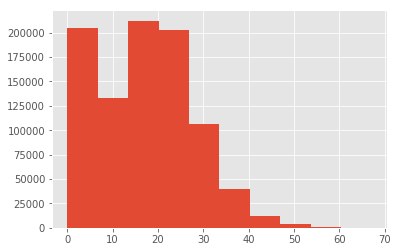

In [187]:
(pd.Series(dfmg.values.ravel())).hist()

In [163]:
dfmg.shape

(16792, 54)

In [164]:
# confident enrichment threshold set to 5 fold 

In [193]:
dfmg = dfmg > 0
dfmg.head(2)

HTMCP-03-06-02001  HTMCP-03-06-02002  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                    False              False   
        858261        862260                    True               True   

                                   HTMCP-03-06-02006  HTMCP-03-06-02007  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                    False              False   
        858261        862260                    True               True   

                                   HTMCP-03-06-02012  HTMCP-03-06-02020  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                    False              False   
        858261        862260                    True               True   

                                   HTMCP-03-06-02026  HTMCP-03-06-02036  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                    False               True   
        858261        862260                    True               True   

                                   HTMCP-03-06-02037  HTMCP-03-06-02040  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                     True              False   
        858261        862260                    True               True   

                                         ...          HTMCP-03-06-02230  \
chr_pro chr_pro_start chr_pro_end        ...                              
1       34081         38080              ...                       True   
        858261        862260             ...                       True   

                                   HTMCP-03-06-02235  HTMCP-03-06-02260  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                    False              False   
        858261        862260                    True               True   

                                   HTMCP-03-06-02261  HTMCP-03-06-02266  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                    False               True   
        858261        862260                    True               True   

                                   HTMCP-03-06-02267  HTMCP-03-06-02268  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                    False              False   
        858261        862260                    True               True   

                                   HTMCP-03-06-02320  HTMCP-03-06-02330  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                    False              False   
        858261        862260                    True               True   

                                   HTMCP-03-06-02332  
chr_pro chr_pro_start chr_pro_end                     
1       34081         38080                    False  
        858261        862260                    True  

[2 rows x 53 columns]

In [154]:
(dfmg.sum(axis=1) > 0.9*54).sum()
(dfmg.sum(axis=1) < 0.1*54).sum()
0.9*54
0.1*54

9476

2547

48.6

5.4

In [188]:
dfmg.head(2)

HTMCP-03-06-02001  HTMCP-03-06-02002  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                  0.00000            0.00000   
        858261        862260                 4.73582            5.10685   

                                   HTMCP-03-06-02006  HTMCP-03-06-02007  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                  0.00000            0.00000   
        858261        862260                 8.52459           17.15151   

                                   HTMCP-03-06-02012  HTMCP-03-06-02020  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                  0.00000             0.0000   
        858261        862260                 9.51227            12.2435   

                                   HTMCP-03-06-02026  HTMCP-03-06-02036  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                  0.00000            2.90228   
        858261        862260                10.53425           11.25621   

                                   HTMCP-03-06-02037  HTMCP-03-06-02040  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                  8.37466            0.00000   
        858261        862260                 7.53719           10.10188   

                                         ...          HTMCP-03-06-02230  \
chr_pro chr_pro_start chr_pro_end        ...                              
1       34081         38080              ...                    3.64580   
        858261        862260             ...                   11.10221   

                                   HTMCP-03-06-02235  HTMCP-03-06-02260  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                  0.00000            0.00000   
        858261        862260                16.66255           10.36509   

                                   HTMCP-03-06-02261  HTMCP-03-06-02266  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                   0.0000            4.45901   
        858261        862260                 11.2431           11.70068   

                                   HTMCP-03-06-02267  HTMCP-03-06-02268  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                  0.00000             0.0000   
        858261        862260                10.25241             9.2453   

                                   HTMCP-03-06-02320  HTMCP-03-06-02330  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                  0.00000             0.0000   
        858261        862260                10.30638             9.6932   

                                   HTMCP-03-06-02332  
chr_pro chr_pro_start chr_pro_end                     
1       34081         38080                  0.00000  
        858261        862260                13.49828  

[2 rows x 53 columns]

In [155]:
# dfmg = dfmg[(dfmg.sum(axis=1) < 0.9*54)&(dfmg.sum(axis=1) > 0.1*54)]

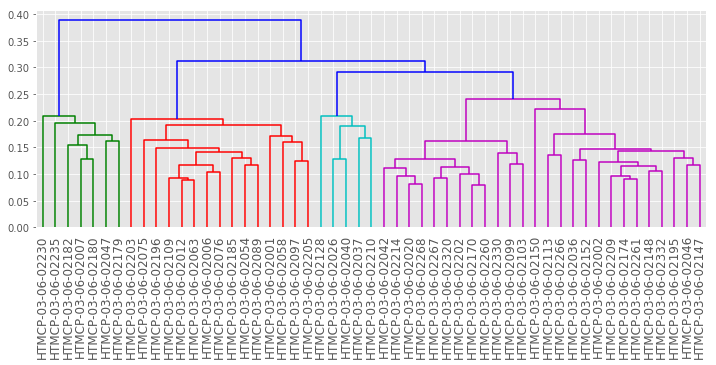

In [190]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
sample_labels = plot_dengrogram(dfmg, ax)

In [121]:
f = f'{wkdir}clinic_covariate_20181009.csv.added'
df_covariates = pd.read_csv(f, index_col='patient', sep='\t')
# df_covariates.strelka_mutations = df_covariates.strelka_mutations.astype('int64')
df_covariates = df_covariates.T.fillna('unknown')
df_covariates.head(2)

patient,HTMCP-03-06-02001,HTMCP-03-06-02002,HTMCP-03-06-02006,HTMCP-03-06-02007,HTMCP-03-06-02012,HTMCP-03-06-02020,HTMCP-03-06-02026,HTMCP-03-06-02036,HTMCP-03-06-02037,HTMCP-03-06-02040,...,HTMCP-03-06-02235,HTMCP-03-06-02256,HTMCP-03-06-02260,HTMCP-03-06-02261,HTMCP-03-06-02266,HTMCP-03-06-02267,HTMCP-03-06-02268,HTMCP-03-06-02320,HTMCP-03-06-02330,HTMCP-03-06-02332
epi_mutated,Mutated,Mutated,Mutated,Mutated,Mutated,Mutated,Mutated,Wild Type,Wild Type,Mutated,...,Wild Type,Mutated,Mutated,Wild Type,Mutated,Wild Type,Mutated,Mutated,Mutated,Mutated
Remodeller,Wild Type,Wild Type,Mutated,Mutated,Mutated,Mutated,Mutated,Wild Type,Wild Type,Mutated,...,Wild Type,Wild Type,Mutated,Wild Type,Mutated,Wild Type,Wild Type,Wild Type,Wild Type,Mutated


patient
HTMCP-03-06-02001    bool
HTMCP-03-06-02002    bool
dtype: object

,Remodeller,Reader,Writer,Eraser,SWI/SNF remodeling complex,SWI/SNF family,ISWI remdelling complexes,SEC (Super Elongation) Complex,INO80/SWR remodelling complexes,chromatin remodelling,EP300/CBP HAT complexes,Polycomb complex,HAT complexes,NuRD complex,compass complex,HDAC complex,GNAT family HAT complexes,MYST family HAT complexes,TFIID basal transcription factor complex or PCAF histone acetylase complex
patient,,,,,,,,,,,,,,,,,,,
HTMCP-03-06-02001,False,True,True,False,False,False,False,False,True,False,True,True,False,False,True,False,True,False,True
HTMCP-03-06-02002,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False


Remodeller    False
Reader        False
dtype: bool

array([False,  True])

patient,HTMCP-03-06-02150,HTMCP-03-06-02230,HTMCP-03-06-02007,HTMCP-03-06-02235,HTMCP-03-06-02026,HTMCP-03-06-02058,HTMCP-03-06-02267,HTMCP-03-06-02330,HTMCP-03-06-02185,HTMCP-03-06-02202,...,HTMCP-03-06-02006,HTMCP-03-06-02012,HTMCP-03-06-02076,HTMCP-03-06-02020,HTMCP-03-06-02170,HTMCP-03-06-02097,HTMCP-03-06-02179,HTMCP-03-06-02001,HTMCP-03-06-02047,HTMCP-03-06-02182
HIV_status,Negative,Positive,Negative,Positive,Negative,Positive,Positive,Positive,Negative,Positive,...,Negative,Negative,Positive,Positive,Positive,Positive,Positive,Positive,Negative,Negative
clinic_histology,Adeno,Squamous,Adenosquamous,Neuroendocrine,Adeno,Adeno,Adeno,Squamous,Squamous,Squamous,...,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Adeno,Squamous,Neuroendocrine,Adeno
tumor_grade,G1,G3,G3,G3,G3,G2,unknown,unknown,G3,G2,...,G3,G2,G3,G2,G3,G3,G3,G2,G3,G3


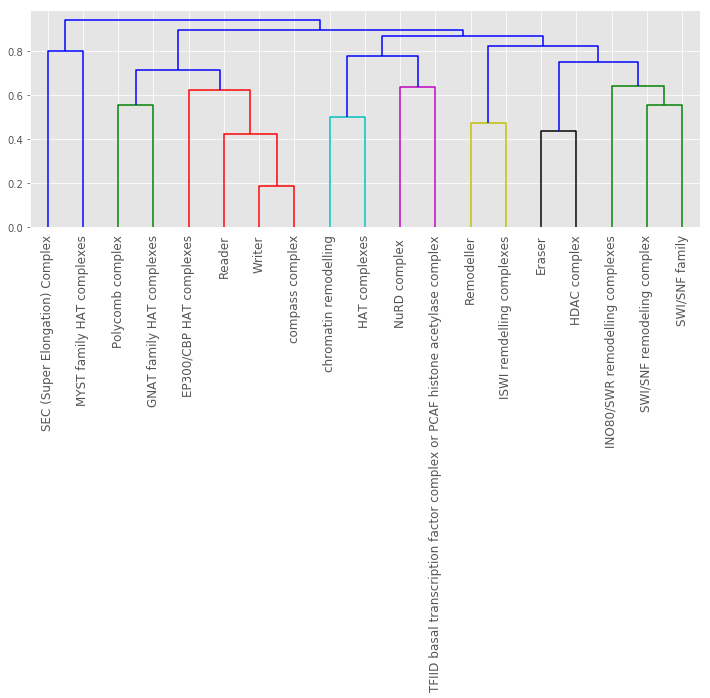

In [122]:
df_covariates = df_covariates.drop(['Testis-specific chromatin protein', 'REST corepressor',
       'ISWI chromatin remdelling','RNF20/40 complex','strelka_mutations', 'HPV_status'])

dftmp = df_covariates.drop(['HIV_status', 'clinic_histology', 'tumor_grade', 'age_at_diagnosis', 'epi_mutated']).apply(lambda x: x.map({'Mutated':True, 'Wild Type':False}))

dftmp.dtypes.head(2)

dftmp = dftmp.T

dftmp.head(2)

dftmp.apply(lambda x: x.all()).head(2)

pd.Series(dftmp.values.ravel()).unique()

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
feature_labels = plot_dengrogram(dftmp, ax)

df_covariates  = df_covariates.reindex(['HIV_status', 'clinic_histology', 'tumor_grade', 'epi_mutated'] + feature_labels)

feature_labels = df_covariates.index.tolist()
df_covariates = order_df(df_covariates, feature_labels, sample_labels)

df_covariates.head(3)

In [123]:
covariate_dict = get_legend_categories(df_covariates)

In [124]:
covariate_dict

{'HIV_status': ['Negative', 'Positive'],
 'clinic_histology': ['Adeno', 'Adenosquamous', 'Neuroendocrine', 'Squamous'],
 'tumor_grade': ['G1', 'G2', 'G3', 'unknown'],
 'epi_mutated': ['Mutated', 'Wild Type']}

In [125]:
df_covariates.shape

(23, 54)

In [126]:
dfmg.shape

(16792, 54)

CPU times: user 4.07 s, sys: 403 ms, total: 4.47 s
Wall time: 4.47 s


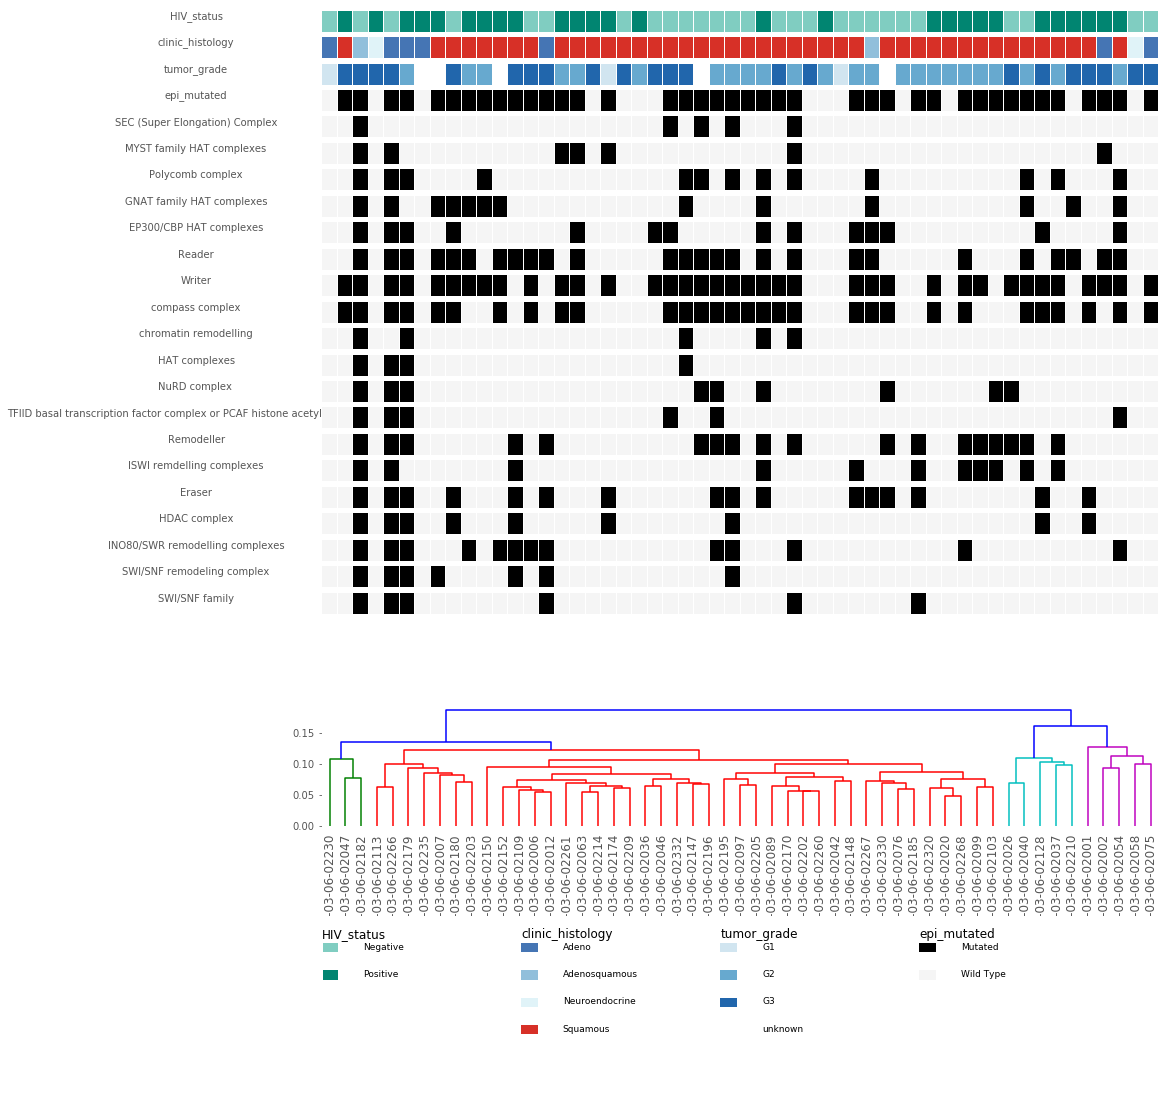

['HTMCP-03-06-02230',
 'HTMCP-03-06-02047',
 'HTMCP-03-06-02182',
 'HTMCP-03-06-02113',
 'HTMCP-03-06-02266',
 'HTMCP-03-06-02179',
 'HTMCP-03-06-02235',
 'HTMCP-03-06-02007',
 'HTMCP-03-06-02180',
 'HTMCP-03-06-02203',
 'HTMCP-03-06-02150',
 'HTMCP-03-06-02152',
 'HTMCP-03-06-02109',
 'HTMCP-03-06-02006',
 'HTMCP-03-06-02012',
 'HTMCP-03-06-02261',
 'HTMCP-03-06-02063',
 'HTMCP-03-06-02214',
 'HTMCP-03-06-02174',
 'HTMCP-03-06-02209',
 'HTMCP-03-06-02036',
 'HTMCP-03-06-02046',
 'HTMCP-03-06-02332',
 'HTMCP-03-06-02147',
 'HTMCP-03-06-02196',
 'HTMCP-03-06-02195',
 'HTMCP-03-06-02097',
 'HTMCP-03-06-02205',
 'HTMCP-03-06-02089',
 'HTMCP-03-06-02170',
 'HTMCP-03-06-02202',
 'HTMCP-03-06-02260',
 'HTMCP-03-06-02042',
 'HTMCP-03-06-02148',
 'HTMCP-03-06-02267',
 'HTMCP-03-06-02330',
 'HTMCP-03-06-02076',
 'HTMCP-03-06-02185',
 'HTMCP-03-06-02320',
 'HTMCP-03-06-02020',
 'HTMCP-03-06-02268',
 'HTMCP-03-06-02099',
 'HTMCP-03-06-02103',
 'HTMCP-03-06-02026',
 'HTMCP-03-06-02040',
 'HTMCP-03

In [194]:
plot_cluster_heatmap(dfmg, df_covariates)